Selected symbol: BRENT_W
✓ Wrote C:\Users\Nikos\OneDrive - Birkbeck, University of London\1. Dissertation\Dissertation Python\zzz.Test\figures\data_section\continuous_futures_BRENT_W_with_rolls.png


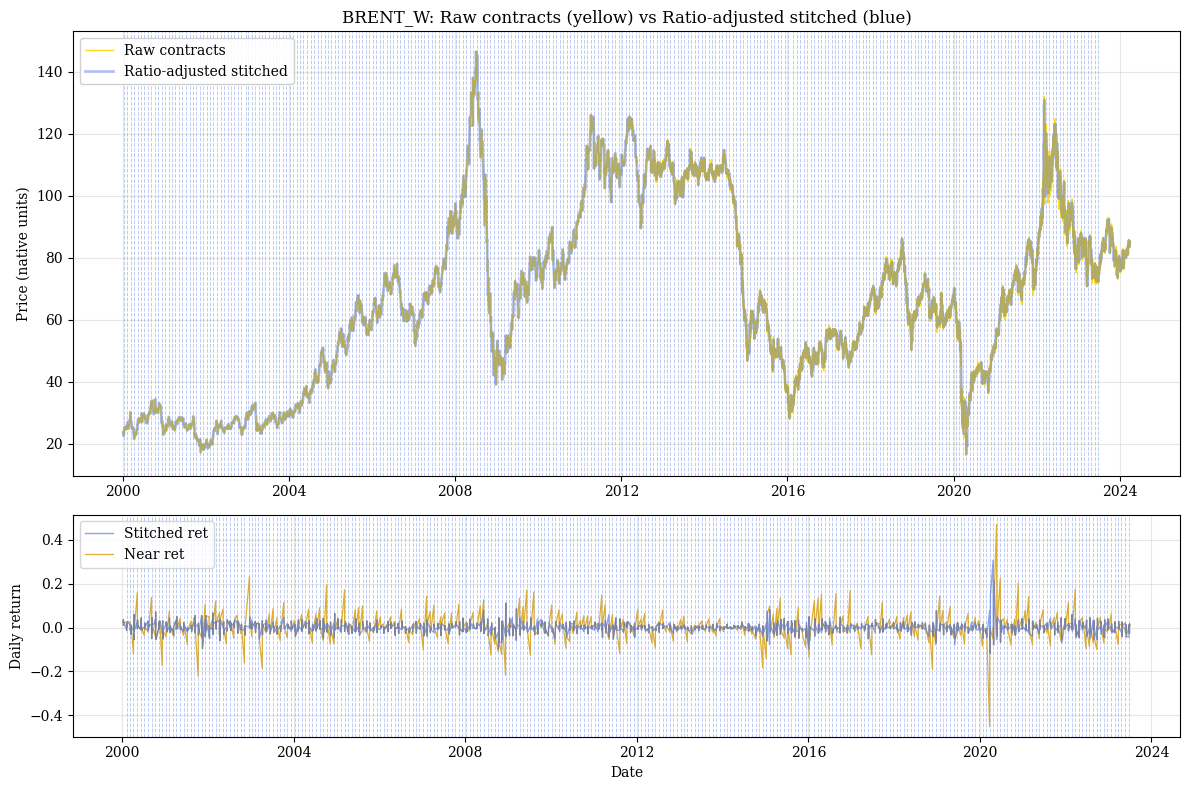

In [8]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from typing import Optional, Tuple

class config:
    DATA_DIR = Path(r"C:\Users\Nikos\OneDrive - Birkbeck, University of London\1. Dissertation\Dissertation Python\zzz.Test\data")
    FIGURES_DIR = Path(r"C:\Users\Nikos\OneDrive - Birkbeck, University of London\1. Dissertation\Dissertation Python\zzz.Test\figures")

OUT_DIR = Path(config.FIGURES_DIR) / "data_section"
OUT_DIR.mkdir(parents=True, exist_ok=True)


FORCE_SYMBOL: Optional[str] = "BRENT_W"
MIN_YEARS = 10
ROLL_OFFSET_BD = 5
FILTER_START = pd.Timestamp("2000-01-03", tz="UTC")
FILTER_END   = pd.Timestamp("2024-03-29", tz="UTC")


def _to_utc(obj):

    if isinstance(obj, pd.DatetimeIndex):
        return obj.tz_convert("UTC") if obj.tz is not None else obj.tz_localize("UTC")
    ser = pd.to_datetime(obj, errors="coerce")
    if isinstance(ser, pd.Series):
        return ser.dt.tz_convert("UTC") if getattr(ser.dt, "tz", None) is not None else ser.dt.tz_localize("UTC")
    return pd.to_datetime(ser).tz_convert("UTC") if getattr(ser, "tzinfo", None) is not None else pd.to_datetime(ser).tz_localize("UTC")


def _read_price_long(path: Path) -> pd.DataFrame:
    wide = pd.read_csv(path)
    def pick(*alts):
        for a in alts:
            if a in wide.columns: return a
        raise KeyError(f"Missing one of {alts} in {path.name}")
    df = wide[[pick("DATETIME","DATE_TIME","DATE","Date"),
               pick("PRICE_CONTRACT","CONTRACT","PriceContract","Contract"),
               pick("PRICE","PX_LAST","CLOSE","Close","Last Price")]].copy()
    df.columns = ["Date","Contract","Close"]
    d = pd.to_datetime(df["Date"], errors="coerce")
    df["Date"] = _to_utc(d).dt.normalize()
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    df = (df.dropna(subset=["Date","Close"])
            .sort_values(["Date","Contract"]))
    df = df[(df["Date"] >= FILTER_START) & (df["Date"] <= FILTER_END)]
    return df

def _read_roll_calendar(path: Path) -> pd.DataFrame:
    r = pd.read_csv(path, parse_dates=["DATE_TIME"])
    r = r.rename(columns={"DATE_TIME":"RollDate","current_contract":"Current","next_contract":"Next"})
    r["ExecDate"] = _to_utc(pd.to_datetime(r["RollDate"], errors="coerce") - BDay(ROLL_OFFSET_BD)).dt.normalize()
    r = r.dropna(subset=["ExecDate","Current","Next"]).sort_values("ExecDate")
    r = r[(r["ExecDate"] >= FILTER_START) & (r["ExecDate"] <= FILTER_END)]
    return r


def _ratio_adjust_stitch(long: pd.DataFrame, roll: pd.DataFrame) -> pd.Series:
    adj_factor, factor = {}, 1.0
    for cur, nxt, ex in zip(roll["Current"][::-1], roll["Next"][::-1], roll["ExecDate"][::-1]):
        adj_factor[cur] = factor
        p_cur = long.query("Contract == @cur & Date == @ex")["Close"]
        p_nxt = long.query("Contract == @nxt & Date == @ex")["Close"]
        if not p_cur.empty and not p_nxt.empty:
            ratio = float(p_nxt.iloc[-1]) / float(p_cur.iloc[0])
            factor *= ratio if ratio < 5 else (1.0 / ratio)
    long = long.copy()
    long["AdjPrice"] = long["Close"] * long["Contract"].map(adj_factor).fillna(1.0)

    stitched = (long.set_index("Date")[["Contract","AdjPrice"]]
                    .groupby("Date").last()["AdjPrice"]
                    .sort_index().asfreq("B").ffill(limit=3))
    gaps = stitched.index.to_series().diff().dt.days.gt(7)
    stitched[gaps] = np.nan
    return stitched.ffill(limit=3).dropna()


def _score_symbol(pc: Path, rc: Path) -> Tuple[str, int]:
    try:
        long = _read_price_long(pc); roll = _read_roll_calendar(rc)
        if long.empty or roll.empty: return (pc.stem, 0)
        return (pc.stem, len(_ratio_adjust_stitch(long, roll)))
    except Exception:
        return (pc.stem, 0)

def auto_pick_symbol(force: Optional[str]) -> str:
    PRICE_DIR = Path(config.DATA_DIR) / "futures" / "multiple_prices_csv"
    ROLL_DIR  = Path(config.DATA_DIR) / "futures" / "roll_calendars_csv"
    if force and (PRICE_DIR/f"{force}.csv").exists() and (ROLL_DIR/f"{force}.csv").exists():
        return force
    if force:
        print(f"Forced symbol {force} not found in both folders; auto-picking.")

    pairs = [(p, ROLL_DIR/f"{p.stem}.csv") for p in PRICE_DIR.glob("*.csv") if (ROLL_DIR/f"{p.stem}.csv").exists()]
    if not pairs:
        raise FileNotFoundError("No (price, roll) CSV pairs found.")

    scored = sorted((_score_symbol(pc, rc) for pc, rc in pairs), key=lambda t: t[1], reverse=True)
    need = int(MIN_YEARS * 252 * 0.7)
    priority = ["SP500","ES","S&P500","WTI_CRUDE","CL","GOLD","GC","BUND","RX","BRENT_W","CO"]
    for fav in priority:
        for sym, n in scored:
            if sym.upper() == fav.upper() and n >= need:
                return sym
    return scored[0][0]


def plot_symbol(symbol: str):
    PRICE_DIR = Path(config.DATA_DIR) / "futures" / "multiple_prices_csv"
    ROLL_DIR  = Path(config.DATA_DIR) / "futures" / "roll_calendars_csv"
    pc, rc = PRICE_DIR/f"{symbol}.csv", ROLL_DIR/f"{symbol}.csv"
    if not pc.exists() or not rc.exists():
        raise FileNotFoundError(f"Missing CSVs for {symbol}")

    long = _read_price_long(pc)
    roll = _read_roll_calendar(rc)
    stitched = _ratio_adjust_stitch(long, roll)

    near_map = (roll[["ExecDate","Current"]].drop_duplicates("ExecDate")
                    .set_index("ExecDate").reindex(stitched.index).ffill()["Current"])
    near_vals = []
    for dt, cur in near_map.items():
        sub = long[(long["Date"] == dt) & (long["Contract"] == cur)]
        near_vals.append(sub["Close"].iloc[-1] if not sub.empty else np.nan)
    near = pd.Series(near_vals, index=stitched.index, name="NearClose").dropna()

    st_r = stitched.pct_change().rename("StitchedRet")
    nr_r = near.pct_change().rename("NearRet")
    ret_idx = st_r.dropna().index.intersection(nr_r.dropna().index)
    st_r, nr_r = st_r.reindex(ret_idx), nr_r.reindex(ret_idx)

    # ---- Figure ----
    plt.rcParams.update({"font.family":"serif"})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), gridspec_kw={"height_ratios":[2.0,1.0]})

    # RAW contracts (bright yellow spaghetti)
    raw_label_done = False
    for c, sub in long.groupby("Contract"):
        if len(sub) >= 2:
            ax1.plot(
                sub["Date"], sub["Close"],
                color="gold", alpha=0.9, linewidth=1.0, zorder=1,
                label="Raw contracts" if not raw_label_done else None
            )
            raw_label_done = True

    ax1.plot(
        stitched.index, stitched.values,
        color="royalblue", linewidth=2.0, alpha=0.4, zorder=3,
        label="Ratio-adjusted stitched"
    )


    for dt in sorted(roll["ExecDate"].unique()):
        ax1.axvline(dt, color="royalblue", linestyle="--", alpha=0.35, linewidth=0.7, zorder=0)

    ax1.set_title(f"{symbol}: Raw contracts (yellow) vs Ratio-adjusted stitched (blue)")
    ax1.set_ylabel("Price (native units)")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="upper left", framealpha=0.9)


    ax2.plot(st_r.index, st_r.values, label="Stitched ret", color="royalblue", linewidth=1.0, alpha=0.6, zorder=2)
    ax2.plot(nr_r.index, nr_r.values, label="Near ret", color="goldenrod", linewidth=0.9, alpha=0.9, zorder=1)
    for dt in sorted(roll["ExecDate"].unique()):
        if ret_idx.min() <= dt <= ret_idx.max():
            ax2.axvline(dt, color="royalblue", linestyle="--", alpha=0.35, linewidth=0.7, zorder=0)
    ax2.set_ylabel("Daily return"); ax2.set_xlabel("Date")
    ax2.grid(True, alpha=0.3); ax2.legend(loc="upper left")

    out = OUT_DIR / f"continuous_futures_{symbol}_with_rolls.png"
    fig.tight_layout()
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print(f"✓ Wrote {out}")


sym = auto_pick_symbol(FORCE_SYMBOL)
print(f"Selected symbol: {sym}")
plot_symbol(sym)
